### 4a and 4b

In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm

In [141]:
tickers = ['AAPL', 'IBM', 'GOOG', 'BP', 'XOM', 'COST', 'GS']
portfolio = pd.DataFrame()
for t in tickers:
    portfolio[t] = wb.DataReader(t, data_source = 'yahoo', start = '2016-01-01', end = '2016-12-31')['Adj Close']

<AxesSubplot:xlabel='Date'>

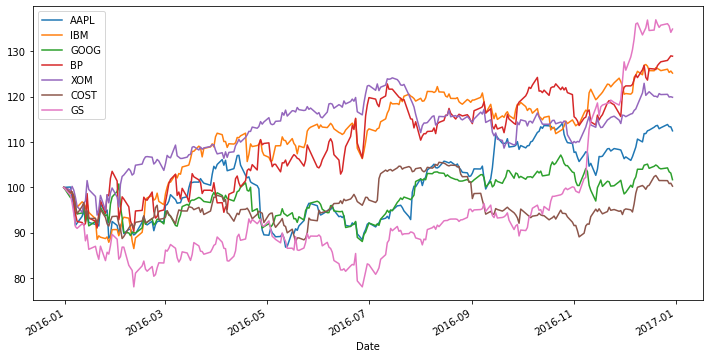

In [142]:
#Showing normalised returns over period
(portfolio / portfolio.iloc[0] * 100).plot(figsize = (12, 6))

In [143]:
#Calculating average daily returns * 250 trading days
returns = (portfolio / portfolio.shift(1)) - 1
annual_returns = returns.mean() * 250
annual_returns

AAPL    0.143666
IBM     0.242533
GOOG    0.036594
BP      0.295028
XOM     0.197975
COST    0.017987
GS      0.333036
dtype: float64

In [144]:
#weighted portfolio return
weights = np.array([0.15, 0.20, 0.20, 0.15, 0.10, 0.15, 0.05])
np.dot(annual_returns, weights)
portfolio_wreturn = np.dot(annual_returns, weights)
print(str(round(portfolio_wreturn, 5) * 100) + ' %')

16.078 %


### Mean returns R is a Nx1 vector. Here R is a 7x1 vector

In [145]:
# R is mean daily return vector
R = np.array(np.mean(portfolio.pct_change()*100)).T
R

array([0.05746637, 0.09701309, 0.01463756, 0.11801109, 0.07919006,
       0.00719493, 0.13321444])

### To get covariance matrix, we use numpy to convert the covariance dataframe into a NxN matrix. We can see V is a 7x7 matrix.

In [146]:
# V is covariance matrix
V = np.array((portfolio.pct_change().dropna()*100).cov())
V

array([[2.16141881, 0.55753348, 0.87032897, 0.78912294, 0.48241631,
        0.51288575, 0.89482608],
       [0.55753348, 1.54931978, 0.53960749, 0.95229692, 0.65054532,
        0.24521015, 0.90096907],
       [0.87032897, 0.53960749, 1.5837625 , 0.49193021, 0.29838956,
        0.50005671, 0.66764214],
       [0.78912294, 0.95229692, 0.49193021, 3.42321774, 1.52225026,
        0.26835895, 1.67794377],
       [0.48241631, 0.65054532, 0.29838956, 1.52225026, 1.45122714,
        0.2159295 , 0.8484438 ],
       [0.51288575, 0.24521015, 0.50005671, 0.26835895, 0.2159295 ,
        1.22579764, 0.47003166],
       [0.89482608, 0.90096907, 0.66764214, 1.67794377, 0.8484438 ,
        0.47003166, 2.85984631]])

### Get V^-1

In [147]:
V_inverse = np.linalg.inv(V)

### We will now test V for Symmetric Positive Definite

*First check: To ensure V is symmetric, we transpose V and check if V' == V. We can use an equality operator.*

In [148]:
V.T == V

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

*Second check: Test if V is positive definite. We create a non-zero Nx1 vector Z and test if z'Vz > 0.*

In [149]:
# create non-zero nx1 vector and test.
number = [1,2,3,4,5,6,7]
z = np.array(number)

np.dot(z.T, np.dot(V,z)) > 0

True

*lastly, we check if V is invertible. Matrix multiplying V^-1 and V should give the identity matrix*

*Identity matrix shows 1 across the diagonal*

In [150]:
pd.DataFrame(np.abs(np.dot(V_inverse, V))).round(14)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Calulating the var and cvar at 95% CI

In [151]:
np.mean(portfolio.pct_change()*100)

AAPL    0.057466
IBM     0.097013
GOOG    0.014638
BP      0.118011
XOM     0.079190
COST    0.007195
GS      0.133214
dtype: float64

In [152]:
portfolio_mean = R.dot(weights)
portfolio_sd = np.sqrt(weights.T.dot(V).dot(weights))
conf_i = 0.05

var_95 = norm.ppf(1-conf_i, portfolio_mean, portfolio_sd)
print(str(round(var_95,4)) + '%')

1.5549%


In [153]:
tail_loss = norm.expect(lambda x: x, loc = portfolio_mean, scale = portfolio_sd, lb = var_95)
cvar_95 = (1 / (conf_i)) * tail_loss
print(str(round(cvar_95,4)) + '%')

1.9335%


## 4c

### With several assumptions below, we can calculate the optimal portfolio.
### Since w can be rebalanced every month, w is the unknown portfolio weights for the optimal portfolio to be solved

$Assumptions$

1. Asset prices adjust to product Market equilibrium. Supply meets demand (risky assets)

2. Investors hold mean-variance efficient portfolios, can borrow and lend at risk-free rate

3. Market where investors and rational and risk-averse, and will choose to hold tangency portfolio

4. Optimal portfolio has highest possible sharpe ratio; representing highest risk-adjusted returns

5. Risk-free rate is US 3-month Treasury note yield at 0.04%

6. Global minimum variance portfolio (RMV) > Risk free rate (Rf)

In [181]:
# incorporate Risk-free asset of 0.066% return
Rf = 0.04

### Calculate e where:
*e = (1,1,...,1)' is a 7x1 unit vector*

In [155]:
units = (1,1,1,1,1,1,1)
e = np.array(units).T
e

array([1, 1, 1, 1, 1, 1, 1])

In [156]:
# R_prime = transpose of R
R_prime = R.T

### Calculate alpha, zeta and delta using R' and V^-1

In [157]:
alpha = np.dot(np.dot(R_prime, V_inverse), e)
alpha

0.06792544607268654

In [158]:
zeta = np.dot(np.dot(R_prime, V_inverse), R)
zeta

0.010101891246744184

In [159]:
delta = np.dot(np.dot(e.T, V_inverse), e)
delta

1.5836662685772682

### Calculate values of a and b, where the linear equation is given by:
$w* = a + (b x Rp)$ 

In [160]:
a = ((np.dot(zeta, np.dot(V_inverse, e))) - (np.dot(alpha, np.dot(V_inverse, R)))) / (np.dot(zeta, delta) - np.square(alpha))
a

array([ 0.00819887,  0.01220152,  0.36609261, -0.10715652,  0.34212302,
        0.57044911, -0.19190862])

In [161]:
b = ((np.dot(delta, np.dot(V_inverse, R))) - (np.dot(alpha, np.dot(V_inverse, e)))) / (np.dot(zeta, delta) - np.square(alpha))
b

array([ 1.01957231,  4.09521967, -4.85624664,  0.74960222, -0.298603  ,
       -5.11753441,  4.40798986])

### Global Minimum Variance Portfolio return is given by alpha/beta

In [162]:
Rmv = alpha / delta
Rmv

0.04289126277451707

In [207]:
# for-loop to iterate through the rows, with steps of 0.01%

port_ret = []
port_vol = []
port_weights = []

for portfolio_return in np.arange(-0.2, 1.71, 0.01):
    port_ret.append(portfolio_return)
    portfolio_var = (1/delta) + (delta / (zeta*delta - np.square(alpha))) * (np.square((portfolio_return - Rmv)))
    portfolio_std = np.sqrt(portfolio_var)
    port_vol.append(portfolio_std)
    w_star = a + (np.dot(b, portfolio_return))
    port_weights.append(w_star)

In [208]:
# minimum-variance portfolio dataframe
MVP = pd.DataFrame({'Portfolio expected return': port_ret, 'Portfolio Std Deviation': port_vol})
MVP

,Portfolio expected return,Portfolio Std Deviation
0,-0.20,2.972959
1,-0.19,2.859479
2,-0.18,2.746374
3,-0.17,2.633695
4,-0.16,2.521497
...,...,...
186,1.66,19.089616
187,1.67,19.207460
188,1.68,19.325305
189,1.69,19.443151


### Plotting the minimum-variance frontier generated by 7 stocks. Plot SD against expected return in increments of 0.01%

<AxesSubplot:xlabel='Portfolio Std Deviation', ylabel='Portfolio expected return'>

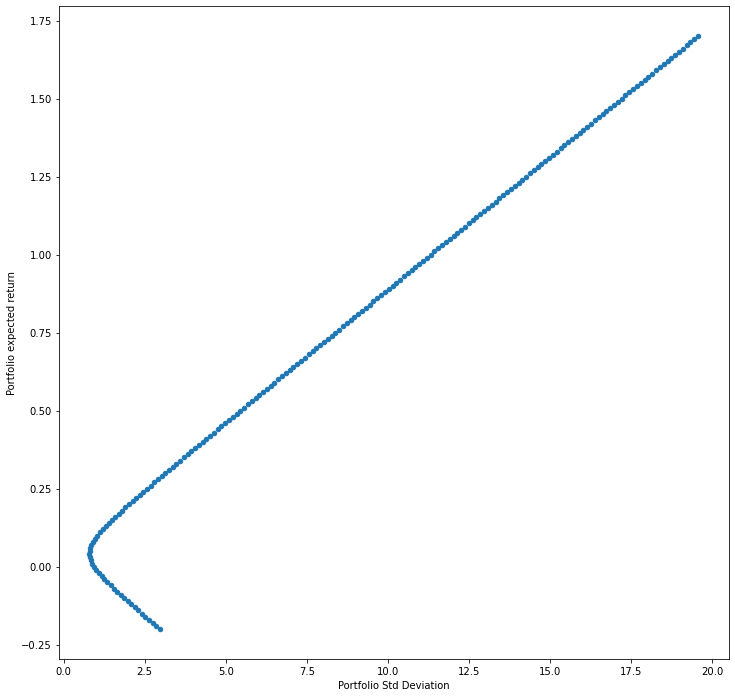

In [209]:
MVP.plot.scatter(y='Portfolio expected return', x = 'Portfolio Std Deviation', figsize = (12,12))

In [210]:
# rearrage formula to below: p_return_w_rf = Rf + (zeta - 2*alpha*Rf + delta*Rf**2)**0.5 * p_std_w_rf
port_rf_ret = []
port_rf_vol = []

for rf_return in np.arange(Rf, 1.71, 0.01):
    port_rf_ret.append(rf_return)
    rf_std = (rf_return - Rf) / (zeta - (2*alpha*Rf) + (delta*Rf**2)) ** 0.5
    port_rf_vol.append(rf_std)
    
RFP = pd.DataFrame({'Portfolio expected return': port_rf_ret, 'Portfolio Std Deviation': port_rf_vol})
RFP.head()

,Portfolio expected return,Portfolio Std Deviation
0,0.04,0.000000
1,0.05,0.117837
2,0.06,0.235674
3,0.07,0.353511
4,0.08,0.471348


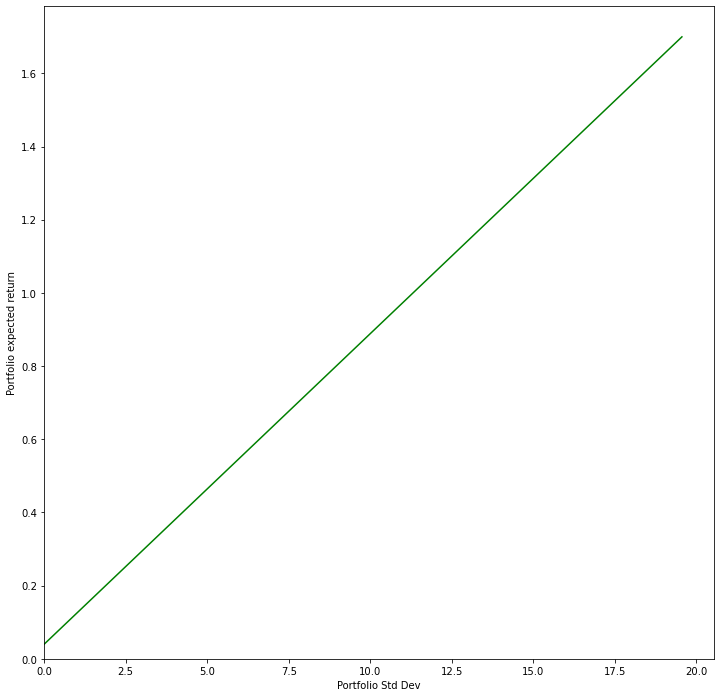

In [211]:
# plot MVP with incorporated Rf asset

x1 = RFP['Portfolio Std Deviation']
y1 = RFP['Portfolio expected return']

plt.figure(figsize=(12,12))
plt.plot(x1, y1, color='green')
plt.axis(ymin=0, xmin=0)
plt.xlabel("Portfolio Std Dev")
plt.ylabel("Portfolio expected return")
plt.show()

### When plotting the 2 charts together, the point of intercept would be the tangent portfolio. This will be the optimal portfolio of risky assets

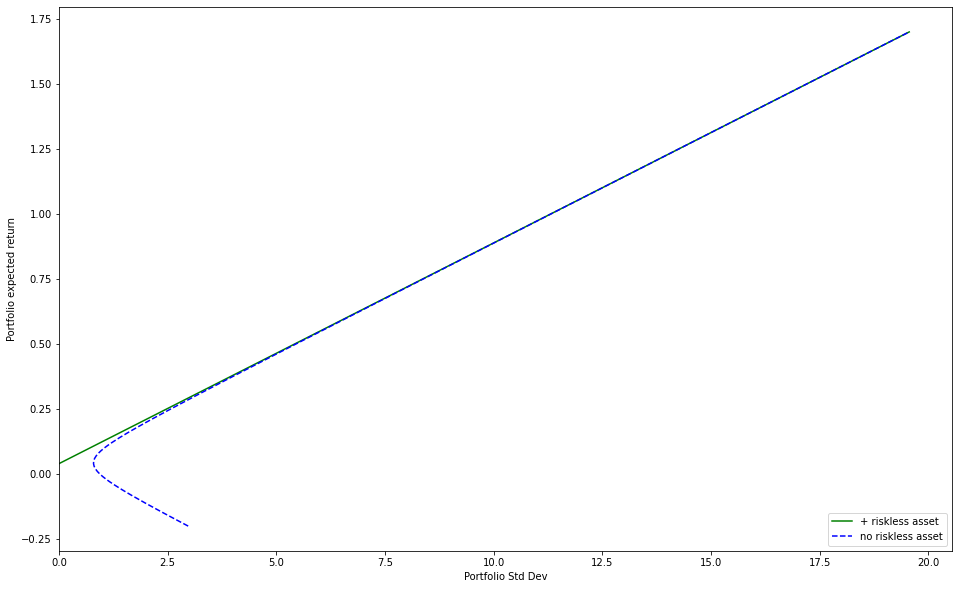

In [212]:
x1 = MVP['Portfolio Std Deviation']
y1 = MVP['Portfolio expected return']
x2 = RFP['Portfolio Std Deviation']
y2 = RFP['Portfolio expected return']

plt.figure(figsize=(16,10))
plt.plot(x2, y2, color='green', label = '+ riskless asset')
plt.plot(x1, y1, color='blue', linestyle='dashed', label = 'no riskless asset')
plt.legend(loc='lower right')
plt.axis(xmin=0)
plt.xlabel("Portfolio Std Dev")
plt.ylabel("Portfolio expected return")
plt.show()

### Now we calculate the sharpe ratio of this optimal portfolio

In [213]:
sharpe = (zeta - (2*alpha*Rf) + (delta*Rf**2)) ** 0.5
print('Sharpe ratio of tangency portfolio: '+str(round(sharpe,4)))

Sharpe ratio of tangency portfolio: 0.0849


### It is hard to see, but the graphs intersect at approx 1.61% expected return

In [214]:
Rtg = (alpha*Rf - zeta) / (delta*Rf - alpha)
print('Expected return of tangency portfolio: '+ str(round(Rtg,4)))

Expected return of tangency portfolio: 1.6128


### Solve for the lagrange multiplier to calculate the optimal portfolio weights

In [215]:
lamb = (Rtg - Rf) / (zeta - (2*alpha*Rf) + (delta*Rf**2))
print('lambda: '+ str(round(lamb, 3)))

lambda: 218.398


In [216]:
opt_weights = np.dot(np.dot(np.array(lamb), V_inverse), (np.array(R) - np.dot(np.array(Rf), e)))
opt_weights

array([ 1.65260791,  6.6171438 , -7.46626592,  1.10183342, -0.13947644,
       -7.68332531,  6.91748254])

### After solving for optimal weights, check that all weights sum back to 1.

In [217]:
round(np.sum(opt_weights),3)

1.0

### Optimal portfolio holding for each of the stocks are given below:

In [218]:
print('Optimal portfolio weights are '+ str(list(np.around(opt_weights, 3))))

Optimal portfolio weights are [1.653, 6.617, -7.466, 1.102, -0.139, -7.683, 6.917]
